In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [30]:
music_data = pd.read_csv('../data/audio_data_genre_augmented.csv') 

In [34]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, color="r", alpha=0.1)
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, color="g", alpha=0.1)
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [22]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

feature_selector = SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.1,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
                                                            min_split_gain=0.0,
                                                            n_estimators=100,
                                                            num_leaves=31,
                                                            reg_alpha=0.0,
                                                            reg_lambda=0.0,
                                                            subsample=1.0,
                                                            subsample_for_bin=200000,
                                                            subsample_freq=0),
                                   max_features=13)

trained_model = LGBMClassifier(boosting_type='gbdt',
                               class_weight=None,
                               colsample_bytree=1.0,
                               importance_type='split',
                               learning_rate=0.1,
                               max_depth=-1,
                               min_child_samples=20,
                               min_child_weight=0.001,
                               min_split_gain=0.0,
                               n_estimators=100,
                               n_jobs=-1,
                               num_leaves=31,
                               objective=None,
                               random_state=2114,
                               reg_alpha=0.0,
                               reg_lambda=0.0,
                               subsample=1.0,
                               subsample_for_bin=200000,
                               subsample_freq=0)

pipeline = Pipeline(steps=[
    ('numerical_imputer', FunctionTransformer(func=lambda X: numerical_imputer.fit_transform(X))),
    ('categorical_imputer', FunctionTransformer(func=lambda X: categorical_imputer.fit_transform(X))),
    ('feature_selection', feature_selector),
    ('trained_model', trained_model)
])

In [23]:
X = music_data.drop("label", axis=1) 
y = music_data["label"]  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [24]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16605
[LightGBM] [Info] Number of data points in the train set: 1008, number of used features: 66
[LightGBM] [Info] Start training from score -2.290751
[LightGBM] [Info] Start training from score -2.361847
[LightGBM] [Info] Start training from score -2.252284
[LightGBM] [Info] Start training from score -2.252284
[LightGBM] [Info] Start training from score -2.383124
[LightGBM] [Info] Start training from score -2.252284
[LightGBM] [Info] Start training from score -2.261763
[LightGBM] [Info] Start training from score -2.427087
[LightGBM] [Info] Start training from score -2.341012
[LightGBM] [Info] Start training from score -2.224376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Pipeline(steps=[('numerical_imputer',
                 FunctionTransformer(func=<function <lambda> at 0x000001AD5EFFA050>)),
                ('categorical_imputer',
                 FunctionTransformer(func=<function <lambda> at 0x000001AD5EFF9CF0>)),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(), max_features=13)),
                ('trained_model',
                 LGBMClassifier(n_jobs=-1, random_state=2114))])

In [25]:
predictions = pipeline.predict(X_test)

In [26]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        44
           1       0.93      0.95      0.94        41
           2       0.80      0.85      0.82        46
           3       0.76      0.84      0.80        45
           4       0.79      0.85      0.82        40
           5       0.86      0.84      0.85        45
           6       0.82      1.00      0.90        45
           7       0.86      0.82      0.84        38
           8       0.88      0.83      0.85        42
           9       0.91      0.62      0.73        47

    accuracy                           0.85       433
   macro avg       0.85      0.85      0.84       433
weighted avg       0.85      0.85      0.84       433



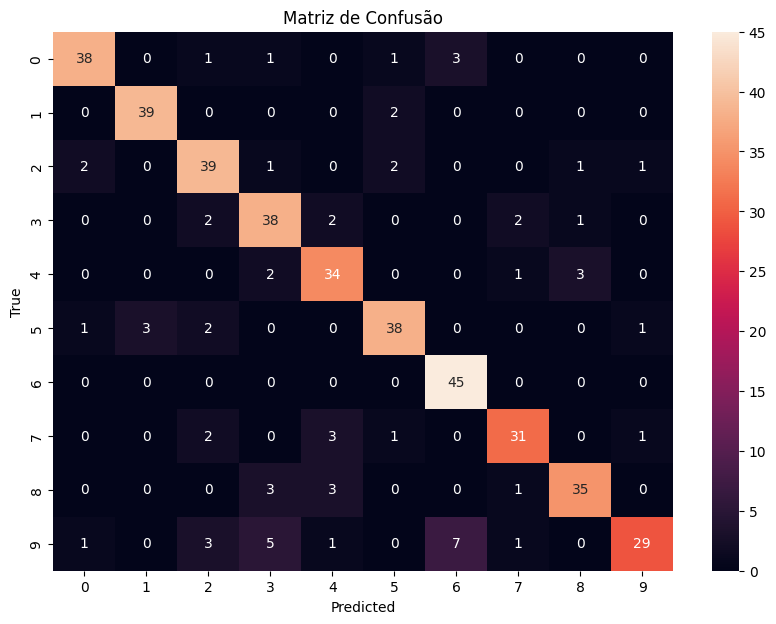

In [27]:
# Calculando e exibindo a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

[LightGBM] [Info] Number of positive: 45, number of negative: 70
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2619
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391304 -> initscore=-0.441833
[LightGBM] [Info] Start training from score -0.441833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<module 'matplotlib.pyplot' from 'c:\\Users\\pedro.mira\\AppData\\Local\\miniconda3\\envs\\stt_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

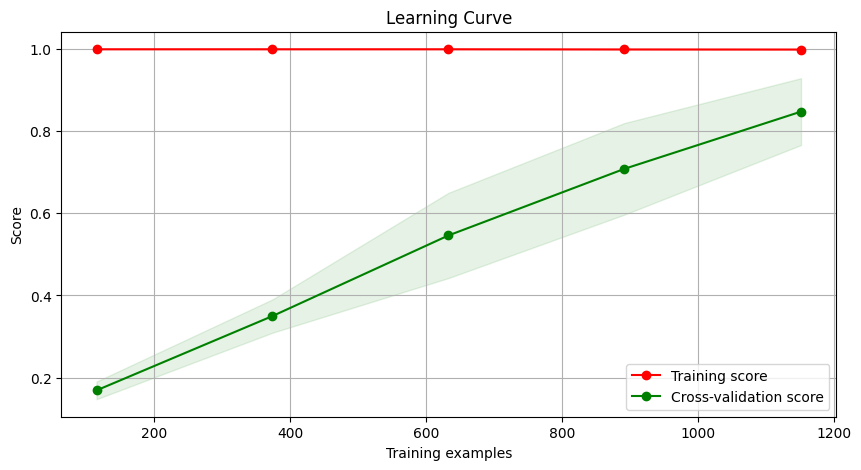

In [35]:
plot_learning_curve(pipeline, "Learning Curve", X, y, cv=5)